In [1]:
using DataFrames
using Underscores
using Pkg
using Chain
using Optim


using Plots
gr()

Plots.GRBackend()

In [2]:
abstract type Team end
struct Aligned <: Team end
struct Unaligned <: Team end

In [3]:
aligned = Aligned()
unaligned = Unaligned()

Unaligned()

In [4]:
world1 = 1
world2 = 2

2

In [5]:
worlds = [world1, world2]

2-element Array{Int64,1}:
 1
 2

In [6]:
teams = [aligned, unaligned]

2-element Array{Team,1}:
 Aligned()
 Unaligned()

In [7]:
function make_rows(teams, worlds, aligned_measure, starting_resources)
    rows = []
    for i in eachindex(teams), j in eachindex(worlds)
        team = teams[i]
        world = worlds[j]
        if world == worlds[1]
            measure = aligned_measure
        else
            measure = 1.0
        end
        if i == j
            resource = starting_resources
        else
            resource = 0.0
        end
        
        row = (team = team, world = world, measure = measure, resource = resource)
        push!(rows, row)
    end
    return rows
end
                


make_rows (generic function with 1 method)

In [8]:
test_data = DataFrame(make_rows(teams, worlds, .1, 10.0^22))

,team,world,measure,resource
,Team,Int64,Float64,Float64
1,Aligned(),1,0.1,1.0e22
2,Aligned(),2,1.0,0.0
3,Unaligned(),1,0.1,0.0
4,Unaligned(),2,1.0,1.0e22


In [106]:
# Utility functions

function get_utility(data; resource_col = "resource")
    return data.measure .* log10.(data[!, resource_col] .+ 1.0)
end


function log_measure(data; resource_col = "resource")
    return log10.(data.measure) .* log10.(data[!, resource_col] .+ 1.0)
end

log_measure (generic function with 1 method)

In [107]:
test_data["utility"] = get_utility(test_data)

4-element Array{Float64,1}:
  2.2
  0.0
  0.0
 22.0

In [108]:
test_data

,team,world,measure,resource,utility,gains
,Team,Int64,Float64,Float64,Float64,Float64
1,Aligned(),1,0.1,1.0e22,2.2,-0.10291
2,Aligned(),2,1.0,0.0,0.0,20.9709
3,Unaligned(),1,0.1,0.0,0.0,2.19574
4,Unaligned(),2,1.0,1.0e22,22.0,-0.0426445


In [109]:
function equal_split_bargaining_strategy(data)
    # A simple bargaining strategy where we assume a successful negotiation
    # results in splitting resources evenly across each world. 
    resources_df = @chain data begin
    groupby(_, :world)
    combine(_, :resource => sum)
    end
    
    num_teams = length(unique(data.team))
    resources_df.resource_sum /= 2
    rename!(resources_df, ("resource_sum" => "bargain_resource")) 
    return innerjoin(data, resources_df, on=:world)
end
    
    
    
    
   

equal_split_bargaining_strategy (generic function with 1 method)

In [110]:
""" data is a DataFrame containing (at least) world and resource columns
team_proportions is a DataFrame containing team, world, and proportion columns
"""
function get_proportional_resource_split(data::DataFrame, team_proportions::DataFrame)
    resources_by_world = @chain data begin
    groupby(_, :world)
    combine(_, :resource => sum => :total_world_resource)
    end
    
    joint_data = innerjoin(team_proportions, resources_by_world, on=:world, makeunique=true)
    joint_data[!, "resource_after_split"] = joint_data.total_world_resource .* joint_data.proportion
    
    return joint_data
end

function get_proportional_resource_split(data::DataFrame, team_proportions::Array)
    team_proportions_df = copy(data)
    team_proportions_df[!, "proportion"] = team_proportions
    return get_proportional_resource_split(data, team_proportions_df)
end

get_proportional_resource_split (generic function with 2 methods)

In [111]:
test_team_proportions = test_data[:, ["team", "world"]]
test_team_proportions[!, "proportion"] .= .5

4-element Array{Float64,1}:
 0.5
 0.5
 0.5
 0.5

In [112]:
get_proportional_resource_split(test_data, test_team_proportions)

,team,world,proportion,total_world_resource,resource_after_split
,Team,Int64,Float64,Float64,Float64
1,Aligned(),1,0.5,1.0e22,5.0e21
2,Aligned(),2,0.5,1.0e22,5.0e21
3,Unaligned(),1,0.5,1.0e22,5.0e21
4,Unaligned(),2,0.5,1.0e22,5.0e21


In [113]:
test_data

,team,world,measure,resource,utility,gains
,Team,Int64,Float64,Float64,Float64,Float64
1,Aligned(),1,0.1,1.0e22,2.2,-0.10291
2,Aligned(),2,1.0,0.0,0.0,20.9709
3,Unaligned(),1,0.1,0.0,0.0,2.19574
4,Unaligned(),2,1.0,1.0e22,22.0,-0.0426445


In [114]:
""" Calculate the Nash Bargaining Solution
per https://en.wikipedia.org/wiki/Cooperative_bargaining#The_Nash_bargaining_solution
The NBS is the source distribution that maximizes the product of each teams gains
relative to the utility they gain on disagreement
(u(x) - u(d))(v(x) - v(d))
"""
function NBS(data, utility_fn, disagreement_strategy; optimizer=NelderMead)
    
    """ Set up the function to be maximized
        as input, take team aligned's share of resources for each
        world. """

    
    """ Optimization libraries assume we're trying to minimize a functionrather than
    maximize, so we just multiply by -1"""
    function loss(aligned_resources) 
        return -1 * get_gains(aligned_resources, data, utility_fn, disagreement_strategy)
    end
    
    inner_optimizer = optimizer()
    results = optimize(loss, [0.0, 0.0], [1.0, 1.0], [0.5, 0.5], Fminbox(inner_optimizer), Optim.Options(time_limit = 2.0))
    return results
end
    
 function get_gains(aligned_resources::Array, data, utility_fn, disagreement_strategy)
    gains_by_team = get_gains_df(aligned_resources, data, utility_fn, disagreement_strategy)

    objective = prod(gains_by_team.gains)
    return objective
end       
    
function get_gains_df(aligned_resources::Array, data, utility_fn, disagreement_strategy)
    unaligned_resources = 1.0 .- aligned_resources
    all_resources = vcat(aligned_resources, unaligned_resources)
    split_resources = get_proportional_resource_split(data, all_resources)
    proposed_utilities = utility_fn(split_resources, resource_col="resource_after_split")
    disagreement_utilities = disagreement_strategy(split_resources, resource_col="resource") 

    data[!, "gains"] .= proposed_utilities .- disagreement_utilities
    gains_by_team = @chain data begin 
        groupby(_, :team)
        combine(_, :gains => sum => :gains)
    end
    return gains_by_team
end   

get_gains_df (generic function with 1 method)

In [115]:
# Check world 2 utility
@chain test_data begin
    filter(:world => ==(world2), _)
    combine(_, :resource => sum => :resource, :measure => maximum => :measure)
    get_utility
end
    

1-element Array{Float64,1}:
 22.0

In [116]:
# Assigning all the resources in world 2 to team aligned should increase its
# utility by the above amount (since it starts at 0), and decrease
# team unaligned's utility by the same amount
get_gains_df([1.0, 1.00], test_data, get_utility, get_utility)

,team,gains
,Team,Float64
1,Aligned(),22.0
2,Unaligned(),-22.0


In [117]:
@time test_NBS = NBS(test_data, get_utility, get_utility; optimizer=NelderMead)

  0.195205 seconds (652.87 k allocations: 38.644 MiB)


 * Status: success

 * Candidate solution
    Final objective value:     -4.493076e+01

 * Found with
    Algorithm:     Fminbox with Nelder-Mead

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.35e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit 2)
    Iterations:    3
    f(x) calls:    165
    ∇f(x) calls:   1


In [118]:
test_NBS.minimizer

2-element Array{Float64,1}:
 0.09351900737980039
 0.09352568445050669

In [119]:
get_proportional_resource_split(test_data, vcat(test_NBS.minimizer, 1 .- test_NBS.minimizer)) 

,team,world,measure,resource,utility,gains,proportion,total_world_resource
,Team,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,Aligned(),1,0.1,1.0e22,2.2,-0.10291,0.093519,1.0e22
2,Aligned(),2,1.0,0.0,0.0,20.9709,0.0935257,1.0e22
3,Unaligned(),1,0.1,0.0,0.0,2.19574,0.906481,1.0e22
4,Unaligned(),2,1.0,1.0e22,22.0,-0.0426445,0.906474,1.0e22


In [120]:
function standard_failure(data)
    return get_utility(data, resource_col="resource")
end

standard_failure (generic function with 1 method)

In [121]:
function probability_from_odds(odds)
    return odds / (odds + 1.0)
end

probability_from_odds (generic function with 1 method)

In [122]:
function odds_from_probability(probability)
    return probability / (1.0 - probability)
end

odds_from_probability (generic function with 1 method)

In [123]:
9 |> probability_from_odds

0.9

In [124]:
.9 |> odds_from_probability

9.000000000000002

In [125]:
function expected_utilities(data, utility_fn, bargaining_strategy, bargain_failure_utility, odds_bargaining_success)
    # Get expected utility grouped by team, based on the utility, bargaining strategy, and probability
    # that bargaining succeeds
    aligned_resource_bargained = bargaining_strategy(data, utility_fn, bargain_failure_utility).minimizer
    data_with_bargain_resources::DataFrame = get_proportional_resource_split(data, vcat(aligned_resource_bargained, 1 .- aligned_resource_bargained))
    bargain_success_utility = utility_fn(data_with_bargain_resources, resource_col="resource_after_split")
    bargain_fail_utility = bargain_failure_utility(data_with_bargain_resources)
    p = probability_from_odds(odds_bargaining_success)
    data_with_bargain_resources[!, "expected_utility"] = p .* bargain_success_utility + (1 - p) .* bargain_fail_utility
    return data_with_bargain_resources
end
    
    

expected_utilities (generic function with 1 method)

In [126]:
import Base.@kwdef

@kwdef struct ExperimentParameters
    teams::Array{Team}
    worlds::Array{Int}
    utility_fn::Function
    bargaining_strategy::Function
    bargain_failure_strategy::Function
    initial_resource::Float64
end

ExperimentParameters2

In [127]:
baseline_parameters = ExperimentParameters(
    teams=teams,
    worlds=worlds,
    utility_fn=get_utility,
    bargaining_strategy=NBS,
    bargain_failure_strategy=get_utility,
    initial_resource=1e22)

ExperimentParameters2(Team[Aligned(), Unaligned()], [1, 2], get_utility, NBS, get_utility, 1.0e22)

In [128]:
log_measure_parameters = ExperimentParameters(
    teams=teams,
    worlds=worlds,
    utility_fn=log_measure,
    bargaining_strategy=NBS,
    bargain_failure_strategy=get_utility,
    initial_resource=1e22)

ExperimentParameters2(Team[Aligned(), Unaligned()], [1, 2], log_measure, NBS, get_utility, 1.0e22)

In [129]:
function aligned_utility(params::ExperimentParameters, odds_bargaining_success, aligned_measure)
    df = make_rows(params.teams, params.worlds, aligned_measure, params.initial_resource) |> DataFrame
    eu = expected_utilities(df, params.utility_fn, params.bargaining_strategy, params.bargain_failure_strategy, odds_bargaining_success)
    return @_ eu |> filter(_.team == aligned, __) |> sum(__.expected_utility)
end

aligned_utility (generic function with 2 methods)

In [130]:
# Change this before running the cells below + graphs
params_to_display = log_measure_parameters

ExperimentParameters2(Team[Aligned(), Unaligned()], [1, 2], log_measure, NBS, get_utility, 1.0e22)

In [131]:
aligned_utility(params_to_display, .1, 100)

2004.0

In [132]:
function aligned_gain_ratio(params::ExperimentParameters2, odds, measure; step_size = 1.01)
    default = aligned_utility(params, odds, measure)
    gain_from_increased_measure = aligned_utility(params, odds, measure * step_size)
    gain_from_increased_bargaining = aligned_utility(params, odds * step_size, measure)
    
    return ((gain_from_increased_measure - gain_from_increased_bargaining) / default)
end
    

aligned_gain_ratio (generic function with 2 methods)

In [133]:
number_of_points = 25

25

In [134]:
measures = [10.0^n for n in LinRange(-3, 3, number_of_points)]

25-element Array{Float64,1}:
    0.001
    0.0017782794100389228
    0.0031622776601683794
    0.005623413251903491
    0.01
    0.01778279410038923
    0.03162277660168379
    0.05623413251903491
    0.1
    0.1778279410038923
    0.3162277660168381
    0.5623413251903487
    1.0
    1.7782794100389228
    3.1622776601683795
    5.623413251903491
   10.0
   17.78279410038923
   31.622776601683793
   56.23413251903491
  100.0
  177.82794100389228
  316.22776601683796
  562.341325190349
 1000.0

In [135]:
odds = [10.0^n for n in LinRange(-2, 2, number_of_points)]

25-element Array{Float64,1}:
   0.01
   0.01467799267622069
   0.021544346900318846
   0.03162277660168379
   0.046415888336127774
   0.06812920690579616
   0.1
   0.14677992676220702
   0.21544346900318828
   0.31622776601683794
   0.4641588833612781
   0.681292069057961
   1.0
   1.467799267622069
   2.1544346900318843
   3.1622776601683795
   4.6415888336127775
   6.812920690579615
  10.0
  14.67799267622069
  21.544346900318846
  31.622776601683793
  46.41588833612777
  68.12920690579615
 100.0

In [136]:
odds_and_measures = Base.product(odds, measures) |> collect

25×25 Array{Tuple{Float64,Float64},2}:
 (0.01, 0.001)       (0.01, 0.00177828)       …  (0.01, 1000.0)
 (0.014678, 0.001)   (0.014678, 0.00177828)      (0.014678, 1000.0)
 (0.0215443, 0.001)  (0.0215443, 0.00177828)     (0.0215443, 1000.0)
 (0.0316228, 0.001)  (0.0316228, 0.00177828)     (0.0316228, 1000.0)
 (0.0464159, 0.001)  (0.0464159, 0.00177828)     (0.0464159, 1000.0)
 (0.0681292, 0.001)  (0.0681292, 0.00177828)  …  (0.0681292, 1000.0)
 (0.1, 0.001)        (0.1, 0.00177828)           (0.1, 1000.0)
 (0.14678, 0.001)    (0.14678, 0.00177828)       (0.14678, 1000.0)
 (0.215443, 0.001)   (0.215443, 0.00177828)      (0.215443, 1000.0)
 (0.316228, 0.001)   (0.316228, 0.00177828)      (0.316228, 1000.0)
 (0.464159, 0.001)   (0.464159, 0.00177828)   …  (0.464159, 1000.0)
 (0.681292, 0.001)   (0.681292, 0.00177828)      (0.681292, 1000.0)
 (1.0, 0.001)        (1.0, 0.00177828)           (1.0, 1000.0)
 (1.4678, 0.001)     (1.4678, 0.00177828)        (1.4678, 1000.0)
 (2.15443, 0.001)    (

In [ ]:
utilities_grid = map(x -> aligned_utility(params_to_display, x...), odds_and_measures)

In [144]:
gains_grid = map(x -> aligned_gain_ratio(params_to_display, x...), odds_and_measures)

LoadError: InterruptException:

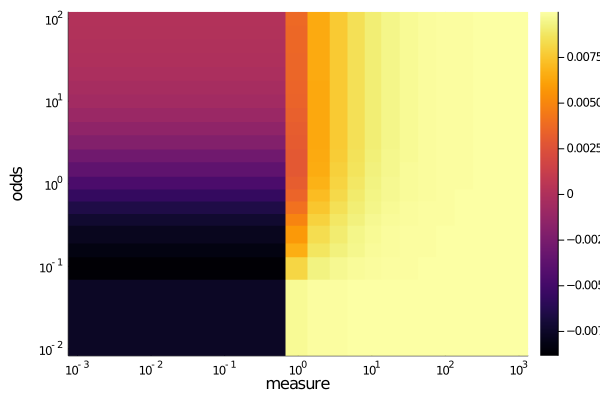

In [141]:
heatmap1 = heatmap(measures, odds, gains_grid, xaxis = :log, yaxis = :log, xlabel = "measure", ylabel = "odds")

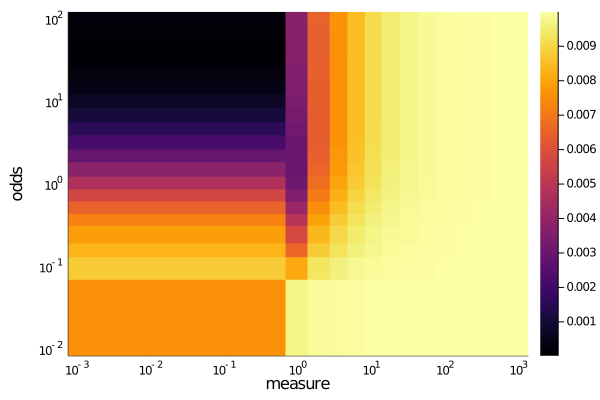

In [142]:
heatmap1_abs = heatmap(measures, odds, abs.(gains_grid), xaxis = :log, yaxis = :log, xlabel = "measure", ylabel = "odds")

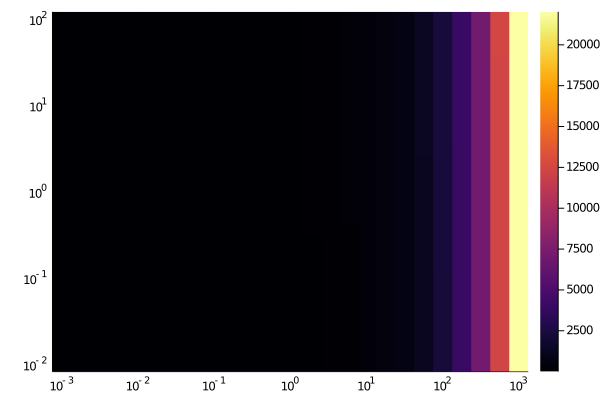

In [143]:
heatmap2 = heatmap(measures, odds, utilities_grid, yaxis = :log10, xaxis = :log10)